# **CIS 545 Final Project - Predicting wins of Underdogs (Upsets) in Tennis Matches**

[Video Presentation](https://drive.google.com/file/d/1jVA_WVHbcvK_gmuwNMx9xFhV_LMwHJ34/view?usp=share_link)

# Introduction and Background



### Problem Statement  
In tennis, an upset is when a lower-ranked (“underdog”) player defeats a higher-ranked (“favorite”) opponent. This is a rare but high-impact event. Predicting upsets can inform coaching strategies, broadcast commentary, and risk management in betting markets.

### Objective & Value Proposition  
Our goal is to build a transparent, reproducible pipeline that forecasts upsets using match-level data. By quantifying how factors like ranking differentials, head-to-head history, recent form, and tournament context interact, we aim to:  
- Give coaches and analysts actionable insights into potential vulnerabilities.  
- Enhance data-driven decision-making for bettors and tournament organizers.  
- Showcase best practices in engineering features and evaluating models for rare-event prediction.

### Dataset Overview  
We aggregate ATP (men’s) and WTA (women’s) tours from 2000 to 2025, all sourced from Jeff Sackmann’s repository (https://github.com/JeffSackmann). Our DataFrame spans 15–20 variables per match, including:  
- **Biographical & Ranking Files**  
  - *Player master*: `player_id`, `first_name`, `last_name`, `hand`, `birth_date`, `country_code`, `height_cm`.  
  - *Weekly rankings*: `ranking_date`, `player_id`, `ranking`, `ranking_points` (nearly complete since 1985).  
- **Results & Match Stats**  
  - Tour-level main-draw, qualifying and challenger, and Futures matches.  
  - Key fields: `surface`, `score`, `match_duration`, `tourney_level`, `round`, plus engineered features (`rank_diff`, `h2h`, `form_diff`).

### Notebook Roadmap  
1. **Data Loading & Preprocessing**: Merge multiple CSVs, resolve missing values, and remove columns excluded from model.
2. **EDA (Exploratory Data Analysis)**
Understand frequency of upsets in dataset and high-level analysis of variables.
3. **Feature Engineering**: Calculate `rank_diff`, rolling head-to-head ratios (`h2h`), recent-form rates (`form_diff`), and encode categorical variables (tourney level, round, surface).
3. **Modeling**:
* Fit logistic regression on raw features to establish a performance floor.  
* Tune Random Forests, XGBoost, and simple neural nets; address class imbalance via weighting and resampling.  
5. **Evaluation & Interpretation**: Compare precision, recall, and ROC/AUC; use SHAP or partial-dependence plots for explainability.  
6. **Conclusion**: Summarize findings, reflect on limitations, and propose improvements.

We hope you find our work informative and welcome any questions you may have!

# Part 1: Data Loading & Preprocessing

For this step, we are trying to import the relevant libraries for all stages of our report (pre-processing, exploratory data analysis, and model selection). These imports primarily span fundamental libraries such as pandas, matplotlib, numpy, and sklearn.

In [ ]:
#Imports:
!pip install xgboost
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy import stats

## 1.1: Data Cleaning WTA and ATP Data

Involves removing irrelevant features, such as player height, hand, and match statistics, to focus on key variables like tournament level, head-to-head record, recent form, and age in predicting upsets.

We extract only the relevant data (2000–2024) from Jeff Sackmann’s repository and combine the WTA and ATP datasets.

### 1.1.1 Loading Data & Convering to Dataframe


In [ ]:

# List of all columns in the dataset
all_columns = [
    'tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num', 'winner_id', 'winner_seed',
    'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry',
    'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df',
    'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
    'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'
]

# List of columns to be excluded from the model
columns_to_drop = [
    'winner_ht', 'loser_ht', 'loser_hand', 'winner_hand', 'tourney_name', 'winner_ioc', 'loser_ioc', 'loser_seed', 'winner_seed', 'minutes'
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_entry', 'loser_entry', 'score', 'draw_size', 'best_of', 'minutes', 'w_ace', 'winner_rank_points', 'loser_rank_points'
]

# Create a DataFrame indicating if the column is included or excluded
model_columns = pd.DataFrame({
    'Column': all_columns,
    'Included in Model': ['No' if col in columns_to_drop else 'Yes' for col in all_columns]
})

# Display the table in the output
# print(model_columns)

# Create an empty list to hold data
combined_data = []

# Define the year range
years = range(2000, 2025)

# Base URLs for ATP and WTA datasets
base_url_atp = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{}.csv"
base_url_wta = "https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_{}.csv"

# Create empty lists to collect DataFrames
atp_dfs = []
wta_dfs = []

# Process the WTA data (starting from 2000)
for year in years:
    wta_url = base_url_wta.format(year)
    try:
        print(f'Reading WTA file: {wta_url}')  # Debugging line
        wta_data = pd.read_csv(wta_url)
        wta_data['tour'] = 'WTA'  # Add a column for tour type

        # Perform the cleaning after reading the file (drop unwanted columns)
        wta_data.drop(columns=columns_to_drop, errors='ignore', inplace=True)

        combined_data.append(wta_data)
    except Exception as e:
        print(f'Error reading WTA file for year {year}: {e}')  # Debugging line

# Process the ATP data (starting from 2000)
for year in years:
    atp_url = base_url_atp.format(year)
    try:
        print(f'Reading ATP file: {atp_url}')  # Debugging line
        atp_data = pd.read_csv(atp_url)
        atp_data['tour'] = 'ATP'  # Add a column for tour type

        # Perform the cleaning after reading the file (drop unwanted columns)
        atp_data.drop(columns=columns_to_drop, errors='ignore', inplace=True)

        combined_data.append(atp_data)
    except Exception as e:
        print(f'Error reading ATP file for year {year}: {e}')  # Debugging line

# Check if any data was added to the combined_data list
if not combined_data:
    print('No data was read. Please check the file paths and filenames.')
else:
    # Combine the data into one DataFrame
    final_data = pd.concat(combined_data, ignore_index=True)

    # Optionally, clean or process the data here (e.g., renaming columns, handling missing values)

    # Save the combined data to a new CSV file
    final_data.to_csv('combined_tennis_data_2000_2025.csv', index=False)

    print("Combined data saved to 'combined_tennis_data_2000_2025.csv'")

Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2000.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2001.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2002.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2003.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2004.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2005.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2006.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2007.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2008.csv
Reading WTA file: https://raw.githubusercontent.com/JeffSackmann

## 1.1.2 Restructuring Data to Eliminate Temporal Leakage

To enforce a strict chronology and prevent both temporal and label leakage, we first sort all matches by tourney_date and match_num, ensuring that any derived features (head-to-head records, recent form, etc.) are computed only from previous matches.

We then recast each row into a consistent “favourite vs. underdog” schema. We do this using ranking to assign fav_* and under_* fields, so that the model cannot cheat by learning from the original winner/loser order.

Finally, we create a binary upset target (1 if the underdog wins, 0 otherwise), producing a clean feature matrix free of future information and false correlations.

**This step eliminates temporal leakage, avoids target leakage from label ordering, and produces a robust dataset for unbiased analysis later on.**

In [ ]:
#restructure data
df = final_data.copy()

#sort by date to ensure no temporal leakage (ie h2h and form is only calculated based on past results)
df = df.sort_values(by=['tourney_date', 'match_num']).reset_index(drop=True)

#The data needs to be restructured so there is no model bias on the winner already having won. We will therefore structure it based on favourite and underdog.

def restructure_match(row):
    # In tennis, lower ranking value means better.
    if row['winner_rank'] <= row['loser_rank']:
        # Winner is the favourite
        fav_id = row['winner_id']
        fav_name = row['winner_name']
        fav_age = row['winner_age']
        fav_rank = row['winner_rank']

        under_id = row['loser_id']
        under_name = row['loser_name']
        under_age = row['loser_age']
        under_rank = row['loser_rank']
        upset = 0  # Favourite won
    else:
        # Winner is the underdog (upset)
        fav_id = row['loser_id']
        fav_name = row['loser_name']
        fav_age = row['loser_age']
        fav_rank = row['loser_rank']

        under_id = row['winner_id']
        under_name = row['winner_name']
        under_age = row['winner_age']
        under_rank = row['winner_rank']
        upset = 1  # Underdog won

    return pd.Series({
        'tourney_id': row['tourney_id'],
        'surface': row['surface'],
        'tourney_level': row['tourney_level'],
        'tourney_date': row['tourney_date'],
        'match_num': row['match_num'],
        'round': row['round'],
        'tour': row['tour'],
        'fav_id': fav_id,
        'fav_name': fav_name,
        'fav_age': fav_age,
        'fav_rank': fav_rank,
        'under_id': under_id,
        'under_name': under_name,
        'under_age': under_age,
        'under_rank': under_rank,
        'upset': upset,
    })

df_pre = df.apply(restructure_match, axis=1)


# Part 2: EDA (Exploratory Data Analysis)

In the EDA we explore the dataset to understand the frequency of upsets. We will also analyze if factors like match frequency between player pairs, recent form, age, tournament level, and surface type influence the likelihood of upsets.

In [ ]:
# Basic summary statistics
final_data.describe()

,tourney_date,match_num,winner_id,winner_age,loser_id,loser_age,winner_rank,loser_rank
count,1.435300e+05,143530.000000,143530.000000,143516.000000,143530.000000,143512.000000,141129.000000,138928.000000
mean,2.011603e+07,103.214255,155155.492733,25.421043,155301.805434,25.454063,78.474006,112.031203
std,7.229895e+04,152.184008,49053.700317,4.149209,49187.661306,4.305718,128.524071,165.644425
min,2.000010e+07,1.000000,100644.000000,14.000000,100644.000000,14.000000,1.000000,1.000000
25%,2.005082e+07,11.000000,104368.000000,22.400000,104339.000000,22.300000,18.000000,35.000000
50%,2.011083e+07,30.000000,200003.000000,25.300000,200007.000000,25.300000,45.000000,68.000000
75%,2.018012e+07,216.000000,201492.000000,28.200000,201505.000000,28.400000,87.000000,115.000000
max,2.024122e+07,2701.000000,266671.000000,47.600000,266671.000000,48.600000,2101.000000,2159.000000


## 2.1 Frequency of Upsets in Dataset

In [ ]:
# Create a new column indicating if an upset occurred
final_data['upset'] = final_data['winner_rank'] > final_data['loser_rank']

# Check the frequency of upsets
upset_count = final_data['upset'].value_counts(normalize=True)
print(upset_count)

upset
False    0.667637
True     0.332363
Name: proportion, dtype: float64


**Interpretation**

67% of the time, the higher-ranked player won (False), and
33% of the time, a lower-ranked player won (an upset, True).

In this dataset, upsets occur approx 33% of the time.

## 2.2 Understanding the Distribution of Key Variables

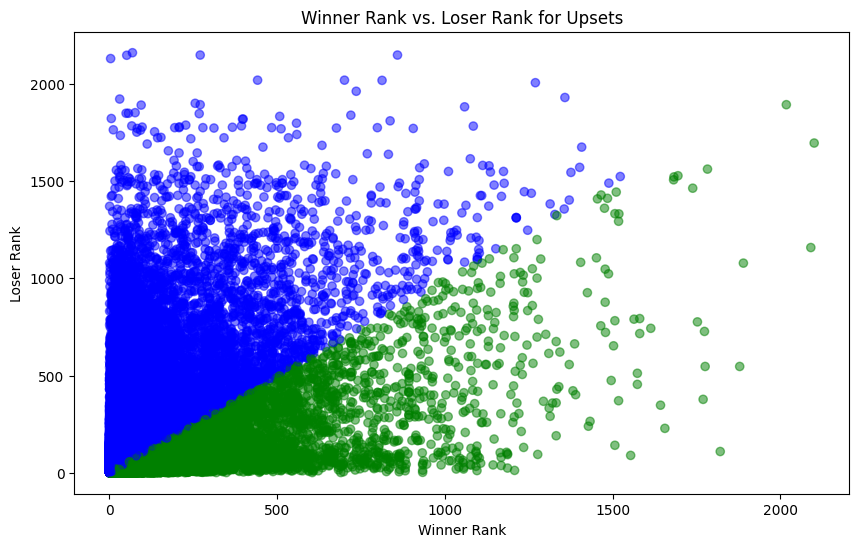

In [ ]:
# Assuming final_data has already been loaded and cleaned

# Create a new column for upset (where lower-ranked player wins)
final_data['upset'] = final_data['winner_rank'] > final_data['loser_rank']

# Define a custom colormap using green for upsets and blue for non-upsets
colors = final_data['upset'].map({True: 'green', False: 'blue'})

# Plot ranking of winner vs loser with color differentiation
plt.figure(figsize=(10, 6))

# Plot all points with the custom color map
plt.scatter(final_data['winner_rank'], final_data['loser_rank'], c=colors, alpha=0.5)

# Title and labels
plt.title('Winner Rank vs. Loser Rank for Upsets')
plt.xlabel('Winner Rank')
plt.ylabel('Loser Rank')

# Show the plot
plt.show()

**Upsets Highlighted in Green**

Below is how to read the chart:

- **Axes**  
  - **x-axis (Winner Rank):** larger → worse player  
  - **y-axis (Loser Rank):** larger → worse player  

- **What is an Upset?**  
  An upset occurs when a lower-ranked (worse) player defeats a higher-ranked (better) player.  
  In the plot, that shows up as a green dot where the winner’s rank number **x** is greater than the loser’s rank number **y**, i.e. the point lies **below** the line `y = x`.

- **Concrete Example**  
  - Point at `(1500, 500)`—the world #1500 player beat the world #500 player.  
  - Since `1500 > 500`, this is an upset, so it’s colored green.

**Interpretation:** There is extremely high density in bottom left (top ranking players winning against top ranking players)

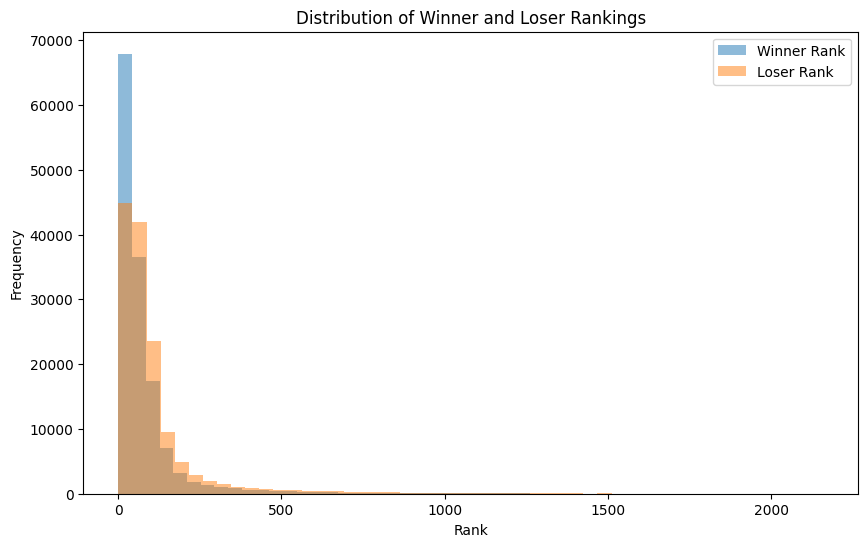

Top-ranked players (1-10) win 15.52% of the matches.


In [ ]:
# Plot distributions of winner and loser rankings
plt.figure(figsize=(10, 6))
plt.hist(final_data['winner_rank'], alpha=0.5, label='Winner Rank', bins=50)
plt.hist(final_data['loser_rank'], alpha=0.5, label='Loser Rank', bins=50)
plt.title('Distribution of Winner and Loser Rankings')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate the percentage of wins by top-ranked players (rank 1-10)
top_ranked_wins = final_data[final_data['winner_rank'] <= 10].shape[0]
total_matches = final_data.shape[0]
top_rank_percentage = (top_ranked_wins / total_matches) * 100

print(f"Top-ranked players (1-10) win {top_rank_percentage:.2f}% of the matches.")

**Interpretation:**

* Winner's Distribution: Winners are mostly top-ranked players (lower rank numbers), with a steep drop-off as rank increases.
* Loser's Distribution: Losers are mostly lower-ranked players (higher rank numbers), but some higher-ranked players still lose.

Both distributions are left-skewed, with winners being predominantly top-ranked and losers mostly lower-ranked.
Top-ranked players dominate the majority of matches, winning ~16% of matches

## 2.3 Head-to-Head Record


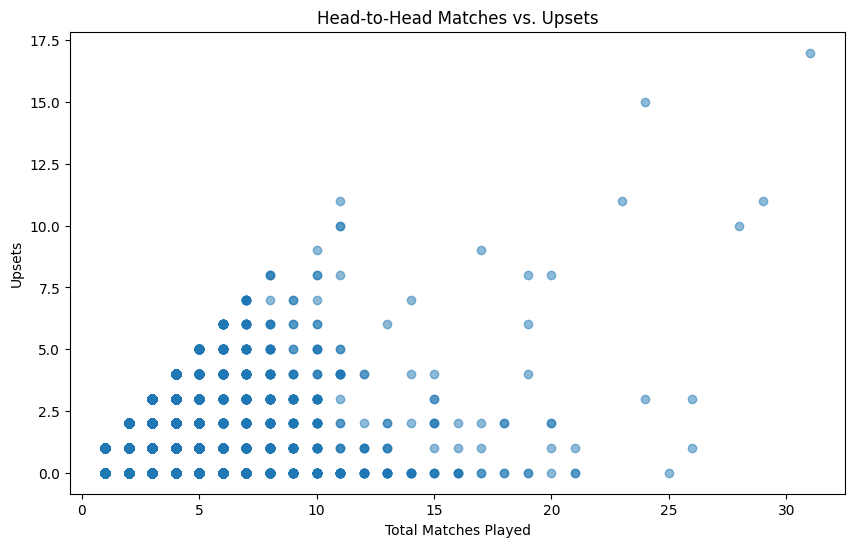

In [ ]:
# Group data by head-to-head (winner vs. loser)
head_to_head = final_data.groupby(['winner_name', 'loser_name']).size().reset_index(name='matches')
head_to_head_upsets = final_data[final_data['upset'] == True].groupby(['winner_name', 'loser_name']).size().reset_index(name='upsets')

# Merge the two to see head-to-head and upsets
head_to_head = pd.merge(head_to_head, head_to_head_upsets, on=['winner_name', 'loser_name'], how='left').fillna(0)

# Plot head-to-head upsets
plt.figure(figsize=(10, 6))
plt.scatter(head_to_head['matches'], head_to_head['upsets'], alpha=0.5)
plt.title('Head-to-Head Matches vs. Upsets')
plt.xlabel('Total Matches Played')
plt.ylabel('Upsets')
plt.show()

**Description of Plot**:

Each point represents a pair of players. The x-axis (Total Matches Played) shows how often they’ve faced each other, while the y-axis (Upsets) shows how many times the lower-ranked player won.

**Interpretation of Plot:**
There’s a dense cluster at the bottom-left, indicating that most player pairs have fewer matches and upsets. On the far right, as total matches increase, upsets also rise, suggesting a higher chance for upsets with more encounters. However, even with many matches, upsets are not guaranteed, as there are points with high x values (total matches) but relatively few y values (upsets).

**Frequent matchups, less upsets:** Some rivalries with many matches (e.g., 20+) show few upsets, indicating consistency in outcomes.

**High upset rate among particular pairs:** A few player pairs with many upsets relative to matches suggest rivalries where lower-ranked players often beat higher-ranked ones.

## 2.4 Age Vs Upset



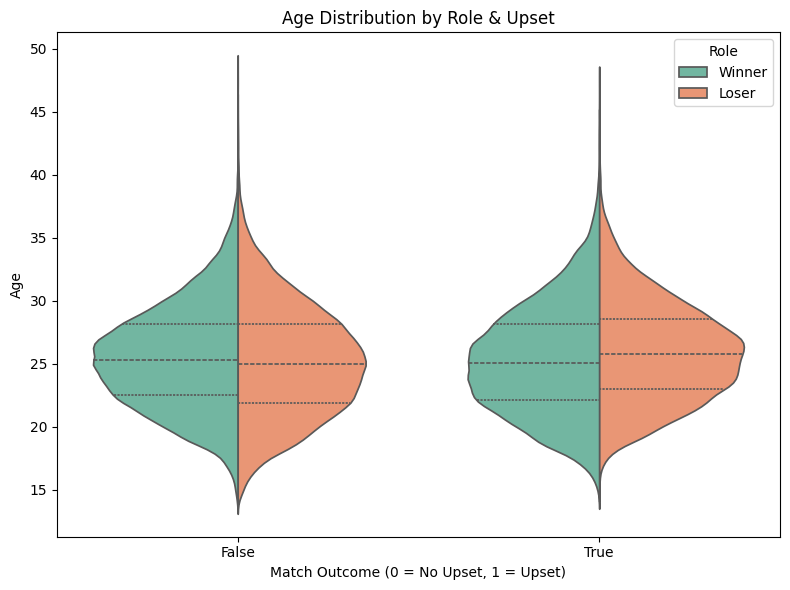

In [ ]:
# 1) Melt winner/loser ages into “long” form
df_age = final_data[['winner_age', 'loser_age', 'upset']].melt(
    id_vars='upset',
    value_vars=['winner_age', 'loser_age'],
    var_name='role',
    value_name='age'
)
df_age['role'] = df_age['role'].map({
    'winner_age': 'Winner',
    'loser_age':  'Loser'
})

# 2) Split violin plot of age distributions by upset vs. non-upset
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df_age,
    x='upset',
    y='age',
    hue='role',
    split=True,
    inner='quartile',
    palette='Set2'
)
plt.xlabel('Match Outcome (0 = No Upset, 1 = Upset)')
plt.ylabel('Age')
plt.title('Age Distribution by Role & Upset')
plt.legend(title='Role')
plt.tight_layout()
plt.show()

Each graph shows the full distribution of ages for winners and losers, with dotted lines for the median and quartiles.

**Interpretation of Plot**  
- **No Upset (0)**:  
  - Winners are tightly clustered around their mid-20s (median ≈ 25 yrs).  
  - Losers skew slightly older (median ≈ 28 yrs).  
- **Upset (1)**:  
  - Winners (the underdogs) exhibit a wider age spread—more density at both younger (<20 yrs) and older (>35 yrs) extremes. However, the median is still in the mid-20s.  
  - Losers (the favorites who fell) are more tightly centered in the mid-20s.

When upsets happen, winners tend to be age outliers. They are either very young prodigies or seasoned players, while in routine matches, winners stay near the mid-20s peak.

**This suggests that age extremes may signal a higher upset probability.**



## 2.5 Impact of Tournament Level and Surface

In [ ]:
# Define the men's tournament level mapping
men_tourney_level_mapping = {
    'G': 1,    # Grand Slams
    'M': 2,    # Masters 1000s
    'A': 3,    # Other tour-level events
    'C': 4,    # Challengers
    'S': 5,    # Satellites/ITFs
    'F': 6,    # Tour finals and other season-ending events
    'D': 7     # Davis Cup
}

# Define the women's tournament level mapping
women_tourney_level_mapping = {
    'P': 1,    # Premier
    'PM': 2,   # Premier Mandatory
    'I': 3,    # International
    '15': 4,   # ITF $15,000 tournaments
    'T1': 5,   # Tier 1
    'T2': 6,   # Tier 2
    'D': 7,    # Fed Cup/Team events
    'E': 8,    # Exhibition
    'J': 9,    # Juniors
    'T': 10    # Team tennis
}

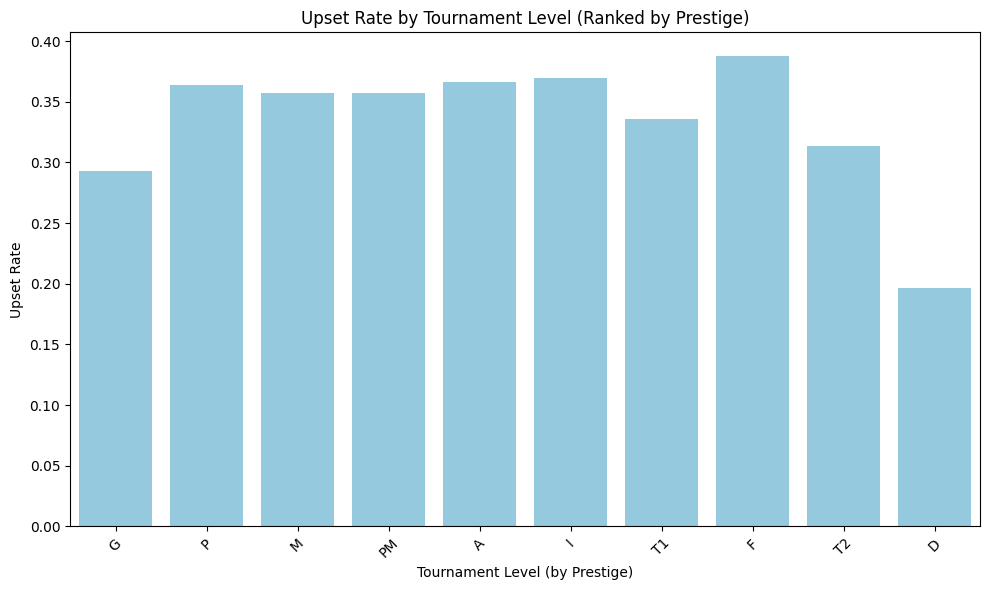

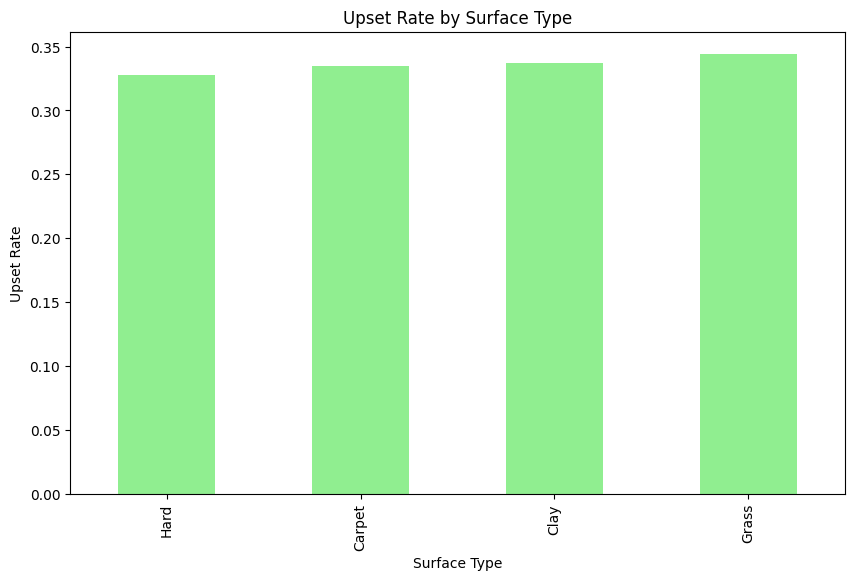

In [ ]:
# 1) Combine men’s and women’s prestige mappings
level_mapping = {
    **men_tourney_level_mapping,
    **women_tourney_level_mapping
}

# 2) Map each match to its prestige rank
final_data['level_rank'] = final_data['tourney_level'].map(level_mapping)

# 3) Compute upset rate by tournament level and preserve the prestige order
upset_by_level = (
    final_data
    .groupby(['tourney_level', 'level_rank'])['upset']
    .mean()
    .reset_index()
    .sort_values('level_rank')
)

# 4) Plot in prestige order
plt.figure(figsize=(10, 6))
sns.barplot(
    data=upset_by_level,
    x='tourney_level',
    y='upset',
    order=upset_by_level['tourney_level'],
    color='skyblue'
)
plt.xticks(rotation=45)
plt.xlabel('Tournament Level (by Prestige)')
plt.ylabel('Upset Rate')
plt.title('Upset Rate by Tournament Level (Ranked by Prestige)')
plt.tight_layout()
plt.show()

# Compute upset rate by surface
upset_rate_by_surface = (
    final_data
    .groupby('surface')['upset']
    .mean()
    .sort_values()
)

# Plot upset rate by surface
plt.figure(figsize=(10, 6))
upset_rate_by_surface.plot(kind='bar', color='lightgreen', title='Upset Rate by Surface Type')
plt.xlabel('Surface Type')
plt.ylabel('Upset Rate')
plt.show()


**Interpretation:**

**1. Upset Rate by Tournament Level:**

Shows the upset rate across different tournament levels, with each tournament level represented by a label (A, CC, D, etc.).

**Insights:**

Lower-tier tournament -> Higher Upset Rates: Some tournament levels like F (lower-tier tournament) show a higher upset rate (~0.35). This suggests that upsets are more common in lower-tier tournaments where the competition might be less predictable.

More Balanced Upset Rates among other tournaments: Other tournament levels (A, W, T1, etc.) show relatively consistent but slightly lower upset rates (~0.25 to 0.30). These might represent more competitive tournaments where the higher-ranked players tend to perform more consistently.

**2. Upset Rate by Surface Type:**

The second graph shows the upset rate across different surface types: Carpet, Clay, Grass, and Hard.

**Insights:**

The upset rates are very similar across the four surfaces (around 0.30 for each), suggesting that the type of surface does not drastically affect the likelihood of an upset in this dataset.

No Surface Bias: There's no surface type that stands out with a significantly higher or lower upset rate. This could imply that upsets are relatively evenly distributed across all surfaces.

**Lower-tier tournaments (e.g. F) have higher upset rates. Surface is not a signal for upsets.**

## 2.6 Hypothesis from EDA

| **Hypothesis**                                      | **Rationale**                                                                                         | **Model Impact**                                                                                     |
|----------------------------------------------------|------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Tournament Level**: Upset rate is higher in lower-tier tournaments. | Lower-tier tournaments show higher upset rates, suggesting more evenly matched players. <br> This leads to unpredictable outcomes. | Include tournament level as a feature to account for higher upset likelihood in lower-tier events. <br> This can help predict upsets in smaller tournaments.     |
| **Surface Type**: Surface type has little impact on upsets. | The upset rate is similar across surfaces, indicating surface type doesn't strongly affect upsets. <br> Thus, surface type may not significantly affect upsets. | Exclude Surface Type from model                     |
| **Head-to-Head Record**: Strong head-to-head performance reduces upset likelihood. | Frequent matchups tend to have fewer upsets, suggesting a player’s historical performance matters. <br> Players with a good head-to-head record are less likely to lose. | Include head-to-head record as a feature to account for past performance against specific opponents. <br> This will help identify strong rivalries and predict outcomes.    |
| **Age**: Older players are more likely to experience upsets. | Older players may have physical decline or inconsistency, leading to more upsets. <br> Age may contribute to match outcomes in the later stages of a player's career. | Include age as a feature, as it may contribute to physical factors or match consistency affecting upsets. <br> Age can highlight players at different stages of their career. |

# Part 3: Feature Engineering
There are some features which are not directly exprsesed in the data which we think could be predictive of upsets. Specifically, these are:
1. **Ranking difference between the winner and the loser**

This is calculater as winner rank-loser rank. If the rank difference is positive, an upset has occured.

2. **Head-to-head record**

We look at the past 5 results between the players (if available) and calculate the % that the winner won.

For example, A beats B. We look at the last 5 matches where A played B, if A beat B 4 times, h2h=0.8.

We chose this feature because it is possible that, even if a player is ranked higher, they might have a particular weakness against a certain player or style.

3. **Recent form**

We look at the last 5 matches the player has played (if available) and calculate the % that was won. This might be useful as it could be easier for a lower ranked player to beat a higher ranked player in bad form. We therefore have a 'winner_form' and a 'loser_form'.

Also, through the EDA we weren't able to identify any highly correlated variables. So, we didn't need to remove any other variables.

## 3.1 Calculating Ranking Difference

In [ ]:
#rank diff
df_pre['rank_diff'] = df_pre['under_rank'] - df_pre['fav_rank']

## 3.2 Calculating Head-to-head record

For each match, we keep a little log of who’s won the last up to five meetings between these two players. Before recording the new result, we look back at that log to see what fraction of those past head-to-head games the “favorite” won (that’s h2h) and how many games we actually had on record (h2h_count). Then we add today’s winner to the log so the next match will include this one.

In [ ]:
h2h = defaultdict(list)
h2h_ratios = []
h2h_counts = []

for _, row in df_pre.iterrows():
    fav = row['fav_id']
    under = row['under_id']
    key = tuple(sorted([fav,under]))
    record = h2h[key]

    last_5 = record[-5:]
    count = len(last_5)

    fav_wins = sum(1 for winner in last_5 if winner==fav)
    ratio = fav_wins/count if count>0 else np.nan

    h2h_ratios.append(ratio)
    h2h_counts.append(count)
    h2h[key].append(row['fav_id'] if row['upset'] == 0 else row['under_id'])

df_pre['h2h'] = h2h_ratios
df_pre['h2h_count'] = h2h_counts

## 3.3 Calculating Recent Form

We were unsure how recent form was calculated, we calculated this from scratch by tracking performance in the last 5 matches.

We track wins (1) and losses (0) to compute a win‐rate for both the favorite (fav_form) and underdog (under_form), then their difference (form_diff).

In [ ]:
#form
#the dataset has their own form column but I am not sure how it is calculated so we will calculate our own
to_drop = [ 'fav_recent_form', 'under_recent_form']
df_pre.drop(columns=to_drop, errors='ignore', inplace=True)

player_history = defaultdict(list)
fav_form = []
under_form = []
for _, row in df_pre.iterrows():
    fav = row['fav_id']
    under = row['under_id']

    fav_recent = player_history[fav][-5:]
    under_recent = player_history[under][-5:]
    fav_streak = sum(fav_recent)/len(fav_recent) if fav_recent else np.nan
    under_streak = sum(under_recent)/len(under_recent) if under_recent else np.nan

    fav_form.append(fav_streak)
    under_form.append(under_streak)

    if row['upset'] == 0:
        player_history[fav].append(1)
        player_history[under].append(0)
    else:
        player_history[fav].append(0)
        player_history[under].append(1)

df_pre['fav_form'] = fav_form
df_pre['under_form'] = under_form
df_pre['form_diff'] = df_pre['under_form'] - df_pre['fav_form']

We drops unused columns (IDs, tournament metadata), fill any missing head‐to‐head or form values with neutral defaults (0.5 or 0), and write out the cleaned DataFrame.

In [ ]:
#dropping columns not used in regression
to_drop = ['tourney_id', 'tourney_date', 'match_num', 'fav_id', 'under_id']
df_pre.drop(columns=to_drop, errors='ignore', inplace=True)
df_pre.to_csv('final.csv')

In [ ]:
#for missing values, assume balanced
df_pre['h2h'] = df_pre['h2h'].fillna(0.5)
df_pre['fav_form'] = df_pre['fav_form'].fillna(0.5)
df_pre['under_form'] = df_pre['under_form'].fillna(0.5)
df_pre['form_diff'] = df_pre['form_diff'].fillna(0.0)
df_pre['h2h_count'] = df_pre['h2h_count'].fillna(0.5)


Next, we group tournament levels and match rounds into broader categories, apply an ordinal encoding so that stronger events receive higher numbers, and one-hot encode the playing surface. Finally, we remove any remaining rows with missing data, leaving us with a fully numeric “final.csv” ready for regression.

In [ ]:

level_group_map = {
    'G': 'G',
    'PM': 'PM_M',
    'M': 'PM_M',
    'P': 'P_T1_F',
    'T1': 'P_T1_F',
    'F': 'P_T1_F',
    'A': 'A_I',
    'I': 'A_I',
    'T2': 'T2',
    'T3': 'T3',
    'T4': 'T4_D',
    'D': 'T4_D',
    'T5': 'T5',
    'CC': 'Other',
    'O': 'Other',
    'W': 'Other'
}

df['tourney_level_grouped'] = df['tourney_level'].map(level_group_map)

order = [['Other', 'T5', 'T4_D', 'T3', 'T2', 'A_I', 'P_T1_F', 'PM_M', 'G']]

encoder = OrdinalEncoder(categories=order)
df_pre['tourney_level_enc'] = encoder.fit_transform(df[['tourney_level_grouped']])


In [ ]:

round_group_map = {
    'ER': 'Early',
    'BR': 'Early',
    'R128': 'Early',
    'RR': 'Early',
    'R64': 'R64',
    'R32': 'R32',
    'R16': 'R16',
    'QF': 'QF',
    'SF': 'SF',
    'F': 'F'
}

df_pre['round_grouped'] = df_pre['round'].map(round_group_map)


round_order = [['Early', 'R64', 'R32', 'R16', 'QF', 'SF', 'F']]

encoder = OrdinalEncoder(categories=round_order)
df_pre['round_enc'] = encoder.fit_transform(df_pre[['round_grouped']])


In [ ]:
#one hot for surface
df_pre = pd.get_dummies(df_pre, columns=['surface'], prefix='surface', drop_first=False)

In [ ]:
df_pre = df_pre.dropna()

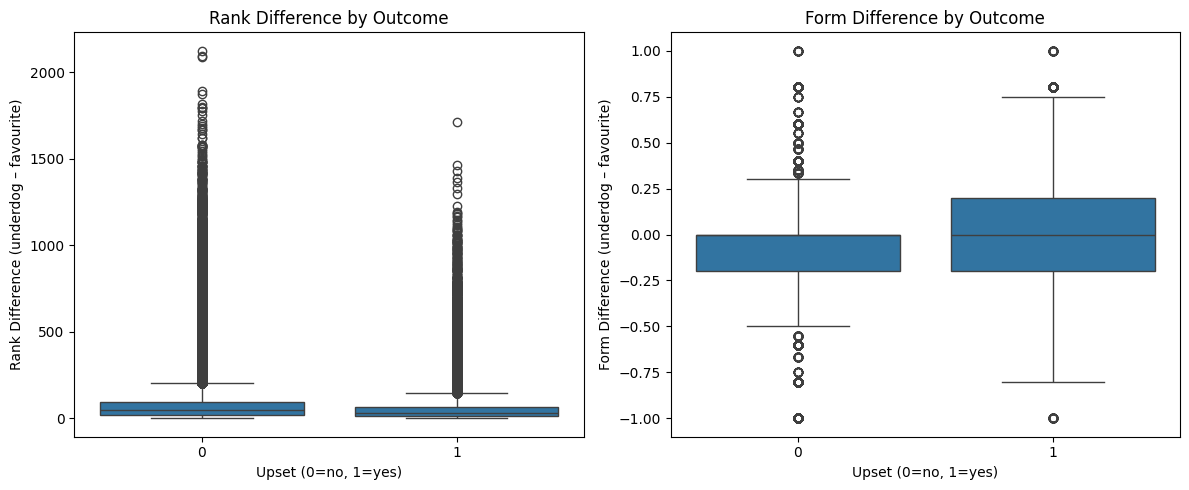

In [ ]:
# create a 1×2 grid of Axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# rank difference boxplot
sns.boxplot(
    data=df_pre,
    x='upset',
    y='rank_diff',
    ax=axes[0]
)
axes[0].set_title('Rank Difference by Outcome')
axes[0].set_xlabel('Upset (0=no, 1=yes)')
axes[0].set_ylabel('Rank Difference (underdog – favourite)')

# form difference boxplot
sns.boxplot(
    data=df_pre,
    x='upset',
    y='form_diff',
    ax=axes[1]
)
axes[1].set_title('Form Difference by Outcome')
axes[1].set_xlabel('Upset (0=no, 1=yes)')
axes[1].set_ylabel('Form Difference (underdog – favourite)')

plt.tight_layout()
plt.show()

**Interpretation of the Boxplots**

1. Rank Difference by Outcome

The graph on the left shows that non-upset matches (upset = 0) have a substantially higher rank difference—indicating that favorites typically defeat opponents who are much lower in the rankings.

In contrast, upset matches (upset = 1) exhibit a smaller median rank gap, which implies that underdogs succeed mainly when the difference in ranking is relatively smaller.

2. Form Difference by Outcome

The graph on the right demonstrates that in non-upset matches, the median form difference is negative, meaning the favorite’s recent win rate exceeds that of the underdog.

For upset matches, the median form difference shifts toward zero or slightly positive, suggesting that underdogs who succeed often have comparable or superior recent form relative to their opponents.

**Together, these patterns indicate that true upsets occur primarily when the ranking gap is not too extreme and the underdog has at least as strong recent performance as the favorite.**

## Part 3: Hypothesis Testing

We want to conduct hypothesis testing on our potential features in order to understand their predicitve power to determine upsets.

- Ranking Difference
- h2h
- Recent form

Null hypothesis H_0: Mean of feature is same in upsets and non-upsets


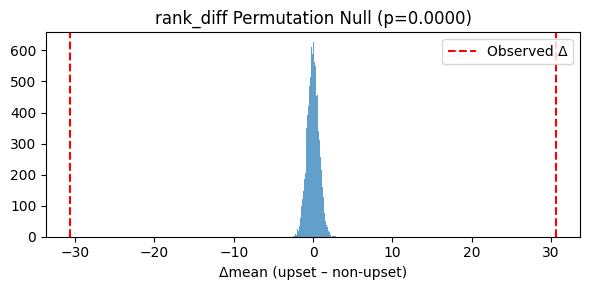

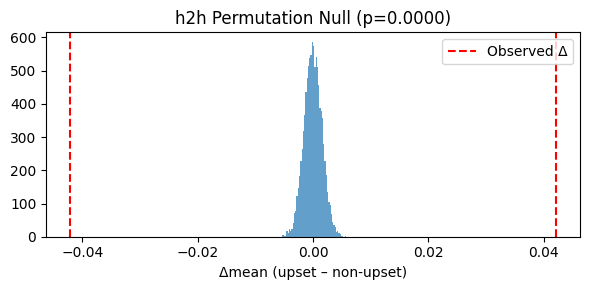

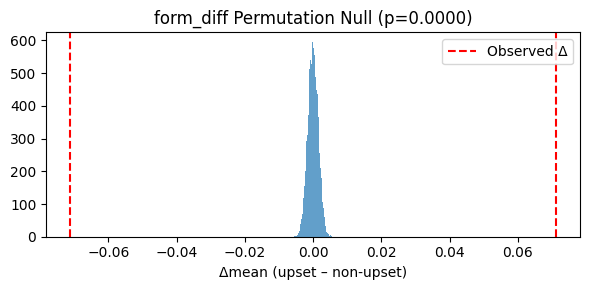

     feature   obs_diff  p_value   decision
0  rank_diff -30.599343      0.0  Reject H0
1        h2h  -0.042061      0.0  Reject H0
2  form_diff   0.071100      0.0  Reject H0


In [ ]:
import random
random.seed(42)

from scipy.stats import ttest_ind

features = ['rank_diff', 'h2h', 'form_diff']
alpha = 0.05
n_permutations = 10000

results = []

for feat in features:
    # Split into upset vs. non-upset groups
    g0 = df_pre.loc[df_pre['upset'] == 0, feat].dropna()
    g1 = df_pre.loc[df_pre['upset'] == 1, feat].dropna()
    n1 = len(g1)

    # Observed mean difference
    obs_diff = g1.mean() - g0.mean()

    # Pool and permute
    pooled = pd.concat([g0, g1]).reset_index(drop=True)
    perm_diffs = np.empty(n_permutations)
    for i in range(n_permutations):
        shuffled = pooled.sample(frac=1, random_state=i).reset_index(drop=True)
        perm_diffs[i] = shuffled.iloc[:n1].mean() - shuffled.iloc[n1:].mean()

    # Compute p-value
    p_val = np.mean(np.abs(perm_diffs) >= abs(obs_diff))
    decision = 'Reject H0' if p_val < alpha else 'Fail to reject H0'
    results.append((feat, obs_diff, p_val, decision))

    # Plot null distribution
    plt.figure(figsize=(6, 3))
    plt.hist(perm_diffs, bins=50, alpha=0.7)
    plt.axvline(obs_diff, color='red', linestyle='--', label='Observed Δ')
    plt.axvline(-obs_diff, color='red', linestyle='--')
    plt.title(f'{feat} Permutation Null (p={p_val:.4f})')
    plt.xlabel('Δmean (upset – non-upset)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Results summary
res_df = pd.DataFrame(results, columns=['feature', 'obs_diff', 'p_value', 'decision'])
print(res_df)


All three engineered features have significant differences in mean values between upset and non-upset matches (p ≪ 0.05 so we can reject Null Hypothesis in every case):

- **Rank Difference**  
  Non-upsets have a much larger average rank gap than upsets.

- **Head-to-Head Record (`h2h`)**
  
  The favourite’s previous win-rate against the respective opponent is significantly higher in non-upsets than in upsets.

- **Form Difference**
  
  Underdogs’ recent form (underdog – favourite) is significantly higher in upsets than in non-upsets.

**Interpretation**  
All features (rank gap, h2h, recent form) are quite different in the upset and non-upset groups. Therefore, we can conclude that these 3 features hold predictive power for determining upsets.



# Part 4: Modelling

After cleaning, pre-processing and feature engineering, we can now begin to work on the model. We can now try to understand the relationship between the player & match statistics and whether we experience an upset.

## 4.1 Logistic Regression

To predict match upsets (a binary outcome), we first applied a straightforward Logistic Regression on our raw, encoded features: favorite/underdog age & rank, tournament‐level and round encodings, plus one-hot surfaces.

We used this run to establish a baseline model: no class weights or feature interactions were applied—instead, the model was trained solely on the raw, non‐engineered features so we could measure how much predictive signal they contain.

### 4.1.1 Linear Regression w.o Engineered Features

In [ ]:
#logistic regression without engineered features

features = [
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)

#Test logistic regression

# Train the model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

# Evaluate predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.51      0.60     18113
           1       0.41      0.64      0.50      9541

    accuracy                           0.56     27654
   macro avg       0.57      0.58      0.55     27654
weighted avg       0.62      0.56      0.57     27654



When evaluated on our stratified 20% hold-out set, the model achieves:

* **Accuracy** ≈ 56% (as compared to ~65% share of non-upsets in the data)
* **Precision / Recall** for “no upset” (class 0): 0.73 / 0.51
* **Precision / Recall** for “upset” (class 1): 0.41 / 0.64

We have traded off precision for recall on the upset class. We are able to identify true upsets (0.64) but have many false positive (with 0.41 precision).

This performance gap suggests our model is underfitting the minority class: the raw features as currently engineered offer very limited predictive power for upsets. To move beyond this baseline, we should:

1. **Engineer richer features** (ranking differentials, recent form metrics, head-to-head stats).
2. **Address class imbalance** (e.g. via class weights in the loss).

3. **Explore more granular models** (e.g. XBoost, Random Forest) that can pick up more complex non-linear patterns.

Only with stronger signal and an imbalance-aware approach will we be able to meaningfully forecast those rare upset outcomes.

## 4.1.2 Logistic Regression w/ Engineered Features


To give the model a better chance at spotting upsets, we added three types of features on top of the basic age, rank and surface encodings:

**Rank and form gaps:**
* rank_diff = favorite’s rank – underdog’s rank
* form_diff = favorite’s recent form – underdog’s recent form
(plus the individual fav_form and under_form scores)

**Head-to-head history:**
* h2h = net wins between the two players
* h2h_count = total number of their past meetings

These features capture momentum and psychological edge, factors our raw baseline could not see.

In [ ]:
#logistic regression with engineered featuers

features = [
    'rank_diff', 'h2h', 'h2h_count',
    'fav_form', 'under_form', 'form_diff',
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)

#Test logistic regression
# Train the model
model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

# Evaluate predictions
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64     18113
           1       0.43      0.62      0.51      9541

    accuracy                           0.58     27654
   macro avg       0.58      0.59      0.57     27654
weighted avg       0.63      0.58      0.59     27654

Accuracy: 0.5840746365806032


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Key Takeaways**
- **Overall accuracy** increases to 58.4% (from 56%).
- **Upset detection** now has lower recall, 62% (down slightly from 64%), precision = 43% (up from 41%), yielding an F1-score of 0.51 (vs. 0.50).  
- **Majority-class bias persists**: the model still favors “no-upset” and fails to identify roughly 38% of actual upsets.  

Incorporating rank gaps, form metrics, and head-to-head history provide a genuine signal. These features enable the model to correctly flag over **6 in 10** upsets but recall and precision are too low for reliable prediction and practical use.

## 4.1.3 Hyperparameter Tuning and Feature Importance

To ensure our Logistic Regression isn’t over- or under-regularized and to see which features truly drive predictions we wrapped scaling and classification in a pipeline and ran a 5-fold grid search over:

* **Penalty:** L1 vs. L2
* **Regularization strength (C):** 0.01, 0.1, 1, 10

This approach both optimizes generalization and, with L1 regularization, yields a sparse coefficient vector that highlights the most predictive inputs.

Best params: {'clf__C': 0.01, 'clf__penalty': 'l1'}
Best CV recall: 0.6283050350170465
Test Set Performance (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       0.74      0.56      0.64     18113
           1       0.43      0.62      0.51      9541

    accuracy                           0.58     27654
   macro avg       0.58      0.59      0.57     27654
weighted avg       0.63      0.58      0.59     27654

Test Set Performance (Threshold 0.3):
              precision    recall  f1-score   support

           0       0.88      0.06      0.11     18113
           1       0.36      0.99      0.52      9541

    accuracy                           0.38     27654
   macro avg       0.62      0.52      0.31     27654
weighted avg       0.70      0.38      0.25     27654

          Feature  Coefficient  Importance
0       rank_diff    -0.383534    0.383534
9        fav_rank     0.188487    0.188487
3        fav_form    -0.151272    0.151272
5  

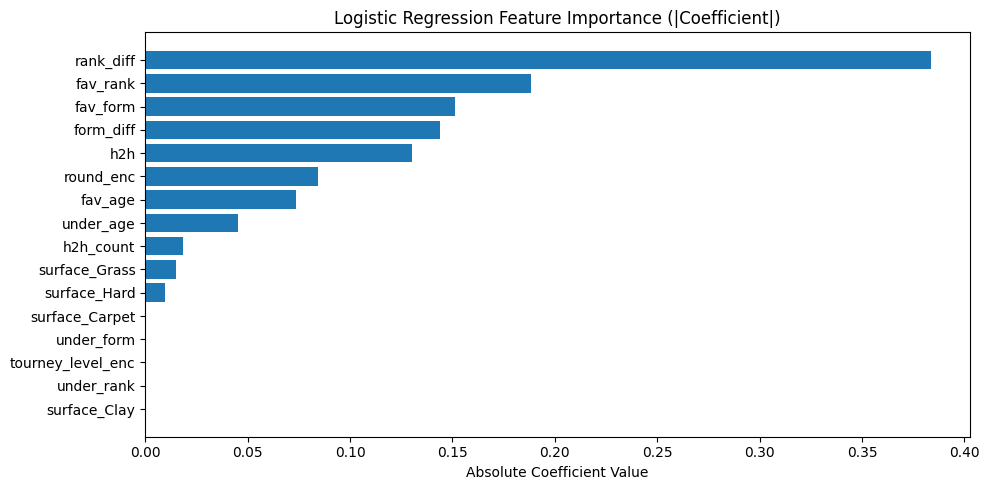

In [ ]:
# 1. Feature selection
features = [
    'rank_diff', 'h2h', 'h2h_count',
    'fav_form', 'under_form', 'form_diff',
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)

# 2. Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)

# 3. Define pipeline and grid
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')) #class weight is balanced to address how there are 33% of upsets - we want to focus on predicting these
])

logistic_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10]
}

# 4. Grid search with 5-fold cross-validation
logistic_search = GridSearchCV(
    logistic_pipeline, logistic_grid, cv=5, scoring='recall', n_jobs=-1
)
logistic_search.fit(X_train, y_train)

print("Best params:", logistic_search.best_params_)
print("Best CV recall:", logistic_search.best_score_)

# 5. Evaluate on test set
best_model = logistic_search.best_estimator_

# Predict with default threshold 0.5
y_pred_default = best_model.predict(X_test)
print("Test Set Performance (Default Threshold 0.5):")
print(classification_report(y_test, y_pred_default))

# Predict probabilities for custom threshold
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_proba >= 0.3).astype(int)

print("Test Set Performance (Threshold 0.3):")
print(classification_report(y_test, y_pred_adjusted))


# 6. Feature importance
coefs = best_model.named_steps['clf'].coef_.flatten()

feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs,
    'Importance': np.abs(coefs)
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df.head(10))

plt.figure(figsize=(10, 5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Logistic Regression Feature Importance (|Coefficient|)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

**Interpretation:**

Sparse Model:
L1 regularization helps simplify the model by "zeroing out" less useful features (like surfaces, tournament level, and underdog rank). This allows the model to focus on a smaller set of features that truly drive predictions.

**Key Drivers:**
- The most important features for predicting outcomes are:
  - **rank_diff** (the largest factor)
  - **fav_rank** (the favorite's rank)
  - **fav_form** (the favorite's form)
  - **form_diff** (difference in recent form between the players)
  - **h2h** (head-to-head)

  These are the strongest predictors of match results.
  Other encoded features (round, ages) remain in the model but have much smaller importances (< 0.09).

**Model Performance**

* Test‐set accuracy remains at 58%, and upset recall at 62%, essentially matching our prior results despite the sparse feature set.
* Precision–recall trade‐off: lowering the classification threshold to 0.3 pushes recall to 99% but crashes accuracy to 38% and precision to 36%, underscoring the difficulty of balancing false positives against catching true upsets.

Even with L1 regularization zeroing out extraneous features, the model’s ability to consistently forecast these rare upsets shows only marginal gains. This highlights the need for richer features and use of imbalance‐aware methods.

## 4.1.4 Applying A Random Forest Model w.o. Features

To assess whether a non-linear ensemble can extract more signal from our basic match data, we trained a Random Forest classifier on the same un-engineered feature set used in Section 4.1.1:

* **Features:** favorite/underdog age & rank, tournament level, round encoding, and surface one-hots

* **Model:** 100 trees, default settings, no class-imbalance adjustments

* **Train/Test split:** stratified 80/20, same random state for comparability

In [ ]:
#random forest without features
features = [
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)


rf_model = RandomForestClassifier(n_estimators=100, random_state=100, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, rf_pred))

Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.87      0.76     18113
           1       0.45      0.19      0.27      9541

    accuracy                           0.64     27654
   macro avg       0.56      0.53      0.52     27654
weighted avg       0.59      0.64      0.59     27654



**Key Takeaways**

* Overall accuracy of 64.0%.

**Non‐upsets (class 0)**  
- **Precision:** 0.67 (when we predict “no upset,” the model is right two‐thirds of the time)  
- **Recall:** 0.87 (it correctly labels 87% of actual non‐upsets)  
- **F1‐score:** 0.76  

**Upsets (class 1)**  
- **Precision:** 0.45 (less than half of predicted upsets are true upsets)  
- **Recall:** 0.19 (it only catches 19% of all actual upsets)  
- **F1‐score:** 0.27  

While the Random Forest excels at identifying non-upset matches, it performs poorly on the minority “upset” class. It detects fewer than one-in-five true upsets despite moderate precision. This extreme imbalance in recall underscores the need for stronger signals (perhaps more features) or imbalance‐aware strategies to boost upset detection.

## 4.1.5 Applying A Random Forest Model with Engineered Features

To combine the benefits of non-linear modeling with our domain-informed predictors, we retrained a 100-tree Random Forest using the full engineered feature set from Section 4.1.2:

In [ ]:


#random forest with features

features = [
    'rank_diff', 'h2h', 'h2h_count',
    'fav_form', 'under_form', 'form_diff',
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)


rf_model = RandomForestClassifier(n_estimators=100, random_state=100, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, rf_pred))




Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.89      0.77     18113
           1       0.47      0.19      0.27      9541

    accuracy                           0.65     27654
   macro avg       0.57      0.54      0.52     27654
weighted avg       0.60      0.65      0.59     27654



**Key Takeaways**

* Accuracy increases to 65.0%, slightly above the raw-feature Random Forest (63.6%) and matching our tuned logistic model.

* Upset recall stays close to the baseline at 19%, and precision to 47%, yielding F1 = 0.27.

* Non-upset detection remains strong (recall = 89%, F1 = 0.77), reflecting the class imbalance.

**Interpretation**

Adding rank differentials, form metrics, and head-to-head history yields only marginal gains for underdog prediction. The model still fails to identify roughly 81% of true upsets.

## 4.1.6 Random Forest Hyperparameter Tuning

To extract more performance from our Random Forest and protect against both under- and over-fitting—we performed a 5-fold grid search over three key parameters:

**Number of trees (n_estimators):** 100, 200

**Maximum tree depth (max_depth):** None, 10, 20

**Number of features to consider at each split (max_features):** “sqrt”, “log2”

All other settings remained at their defaults, and accuracy was used as the scoring metric.

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest Test Performance (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       0.75      0.56      0.64     18113
           1       0.44      0.64      0.52      9541

    accuracy                           0.59     27654
   macro avg       0.59      0.60      0.58     27654
weighted avg       0.64      0.59      0.60     27654

Random Forest Test Performance (Threshold 0.3):
              precision    recall  f1-score   support

           0       0.88      0.14      0.24     18113
           1       0.37      0.97      0.54      9541

    accuracy                           0.42     27654
   macro avg       0.63      0.55      0.39     27654
weighted avg       0.71      0.42      0.34     27654

              Feature  Importance
0           rank_diff    0.231121
9            fav_rank    0.220447
10         under_rank    0.106733
5           form_diff    0.085718
7           under_age    0.069443
6             fav_age    0.068526
3   

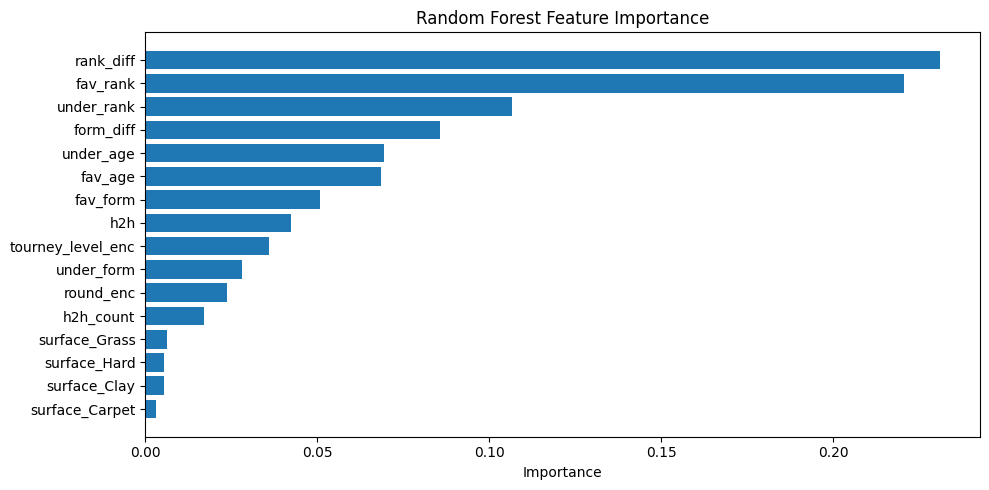

In [ ]:
# Define pipeline
rf_pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=100, class_weight='balanced'))
])

# Hyperparameter grid
rf_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__max_features': ['sqrt', 'log2']
}

# Grid search with 5-fold cross-validation
rf_search = GridSearchCV(
    rf_pipeline, rf_grid, cv=5, scoring='recall', n_jobs=-1
)
rf_search.fit(X_train, y_train)

# Get best model
best_rf = rf_search.best_estimator_

# Predict with default threshold (0.5)
y_pred_rf_default = best_rf.predict(X_test)

# Predict probabilities for threshold adjustment
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_rf_adjusted = (y_proba_rf >= threshold).astype(int)

# Classification reports
print("Random Forest Test Performance (Default Threshold 0.5):")
print(classification_report(y_test, y_pred_rf_default))

print(f"Random Forest Test Performance (Threshold {threshold}):")
print(classification_report(y_test, y_pred_rf_adjusted))

# Feature importances
importances = best_rf.named_steps['clf'].feature_importances_

feat_imp_rf_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_rf_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feat_imp_rf_df['Feature'], feat_imp_rf_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

This tuned Random Forest (200 trees, max_depth=10, max_features='sqrt') shows a modest improvement over our earlier model:

- **Accuracy:** increased to **59%** (from ~58%).  
- **Upset detection:** recall rose to **64%** (from 62%), precision to **44%** (from 43%), yielding **F1 = 0.52** (vs. 0.51).

**Why it helped**  
- **Depth control (max_depth=10):** prevents trees from growing too deep and overfitting noise.  
- **Feature subsetting (max_features='sqrt'):** adds randomness that lowers inter-tree correlation and increases ensemble robustness.  
- **More estimators (100 → 200 trees):** smooths out variance, providing a small but measurable boost in stability and overall performance.  

## 4.1.7 Apply XGBoost Model w.o. features

To understand whether a gradient-boosted tree ensemble can uncover more complex patterns than Random Forest, we trained an XGBoost classifier on the same un-engineered feature set used in Section 4.1.1.

All other settings remained were at their defaults value, and we used the same stratified 80/20 split.

In [ ]:
#xgboost without features
features = [
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)


# to replicate the "balanced" class weights in previous models
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

xgb_model = XGBClassifier( eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost:")
print(classification_report(y_test, xgb_pred))


XGBoost:
              precision    recall  f1-score   support

           0       0.74      0.54      0.62     18113
           1       0.42      0.64      0.51      9541

    accuracy                           0.57     27654
   macro avg       0.58      0.59      0.57     27654
weighted avg       0.63      0.57      0.59     27654



**Key Observations**

- **Non-upset recall:** 54%, roughly matching logistic regression (56%) but well below Random Forest (89%), indicating XGBoost shifts focus toward catching upsets at the expense of missing many non-upsets.  
- **Upset recall:** 64% (precision 42%, F1-score 0.51), on par with Random Forest (64%) and tuned logistic (62%), showing that boosting alone yields only incremental improvements without deeper feature engineering.  
- **Overall accuracy:** 57%, which is between tuned logistic (58%) and Random Forest (59%).

**Interpretation**

XGBoost’s ability to model non-linear interactions does not significantly outperform simpler models on our raw and engineered features: it achieves similar upset recall but trades off non-upset detection, and accuracy remains constrained by severe class imbalance.To push performance further, we’ll next fit a hyperparameter‐tuned XGBoost model and inspect its feature importances.


## 4.1.8 Apply XGBoost Model with features

To harness both non-linear pattern learning and our domain-informed predictors, we trained an XGBoost classifier on the full engineered feature set:

* Rank & form gaps (rank_diff, form_diff, plus individual fav_form/under_form)

* Head-to-head metrics (h2h, h2h_count)

* Raw match descriptors (favorite/underdog age & rank, tournament level, round, surface one-hots)

All other parameters remained at their defaults (eval_metric='logloss'), using the same stratified 80/20 split.

In [ ]:
#xgboost with features
features = [
    'rank_diff', 'h2h', 'h2h_count',
    'fav_form', 'under_form', 'form_diff',
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)

neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

xgb_model = XGBClassifier( eval_metric='logloss', scale_pos_weight=scale_pos_weight,random_state=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost:")
print(classification_report(y_test, xgb_pred))
print("Accuracy:", accuracy_score(y_test, xgb_pred))

XGBoost:
              precision    recall  f1-score   support

           0       0.75      0.57      0.64     18113
           1       0.43      0.63      0.52      9541

    accuracy                           0.59     27654
   macro avg       0.59      0.60      0.58     27654
weighted avg       0.64      0.59      0.60     27654

Accuracy: 0.5894626455485644


**Key Takeaways**

- **Accuracy:** 58.9%, below our tuned logistic (≈65.7%) and Random Forest (64.0%) benchmarks.  
- **Upset detection:** recall rose slightly to **63%** (from 62%), precision held at **43%**, yielding an **F1-score of 0.52** (vs. 0.51).  
- **Non-upset detection:** recall is **57%**, precision **75%**, and F1-score **0.64**, reflecting continued majority-class bias.

**Interpretation**

XGBoost’s ability to capture non-linear interactions delivers only marginal gains for upsets. The model still misses roughly one-in-three true upsets while favoring non-upsets.

This persistent class imbalance underlines the need for richer features and imbalance-aware training.
In Section 4.1.9, we’ll therefore perform a targeted hyperparameter search on our XGBoost classifier and inspect its feature importances to fine-tune model complexity and to identify which engineered signals most effectively predict upsets.


## 4.1.9 XGBoost Hyperparameter Tuning & Feature Importance

To extract maximum predictive power from our boosted-tree model, we performed a 5-fold grid search over four key hyperparameters:

* n_estimators: 100, 200
* max_depth: 3, 6
* learning_rate: 0.01, 0.1
* subsample: 0.8, 1.0

All other settings remained at their defaults (eval_metric='logloss'), and we continued to use a stratified 80/20 split for train/test.

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:10:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
XGBoost Best CV Recall: 0.6798731014866761
XGBoost Test Performance (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       0.75      0.52      0.61     18113
           1       0.42      0.67      0.52      9541

    accuracy                           0.57     27654
   macro avg       0.59      0.60      0.57     27654
weighted avg       0.64      0.57      0.58     27654

XGBoost Test Performance (Threshold 0.3):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18113
           1       0.35      1.00      0.51      9541

    accuracy                           0.35     27654
   macro avg       0.17      0.50      0.26     27654
weighted avg       0.12      0.35      0.18     27654

              Feature  Importance
0           rank_diff    0.318156
9            fav_rank  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


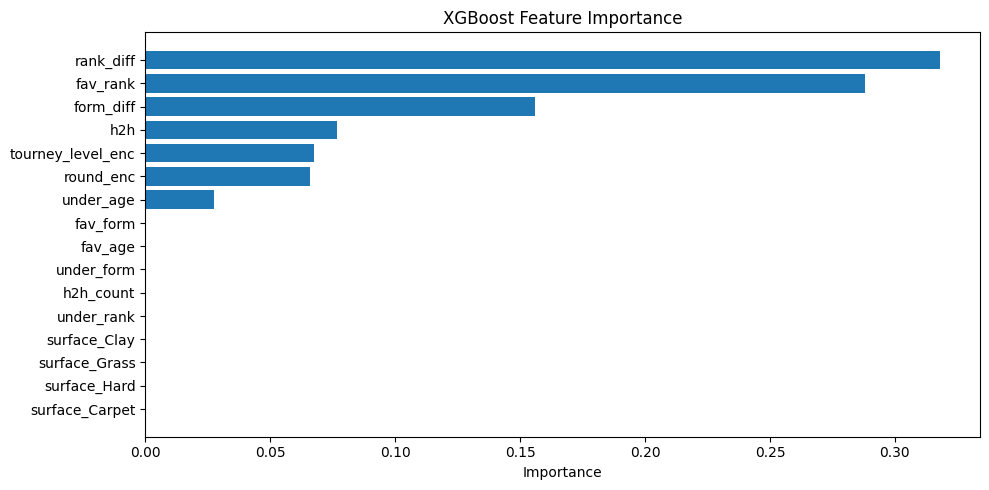

In [ ]:
# 1. Feature selection
features = [
    'rank_diff', 'h2h', 'h2h_count',
    'fav_form', 'under_form', 'form_diff',
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)

# 3. Calculate scale_pos_weight
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

# 4. Define pipeline
xgb_pipeline = Pipeline([
    ('clf', XGBClassifier(
        eval_metric='logloss',
        random_state=100,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False
    ))
])

# 5. Hyperparameter grid
xgb_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.01, 0.1],
    'clf__subsample': [0.8, 1.0]
}

# 6. GridSearchCV
xgb_search = GridSearchCV(
    xgb_pipeline, xgb_grid, cv=5, scoring='recall', n_jobs=-1
)
xgb_search.fit(X_train, y_train)

print("XGBoost Best Params:", xgb_search.best_params_)
print("XGBoost Best CV Recall:", xgb_search.best_score_)

# 7. Best model
best_model = xgb_search.best_estimator_

# 8. Predictions
# Predict with default threshold (0.5)
y_pred_default = best_model.predict(X_test)

# Predict probabilities for threshold adjustment
y_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_adjusted = (y_proba >= threshold).astype(int)

# 9. Classification reports
print("XGBoost Test Performance (Default Threshold 0.5):")
print(classification_report(y_test, y_pred_default))

print(f"XGBoost Test Performance (Threshold {threshold}):")
print(classification_report(y_test, y_pred_adjusted))

# 10. Feature Importances
importances = best_model.named_steps['clf'].feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df.head(10))

# 11. Plot
plt.figure(figsize=(10, 5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



**Interpretation**

- **Primary predictors:** The underdog–favorite ranking gap (`rank_diff`), the favorite’s absolute rank (`fav_rank`), and the recent‐form differential (`form_diff`) have the highest feature importance under XGBoost.  

- **Head‐to‐head metrics:** Historical matchup statistics (`h2h`, `h2h_count`) remain secondary but still contribute meaningfully.  
- **Contextual features:** Tournament level (`tourney_level_enc`) and match round (`round_enc`) have moderate importance once the engineered ranking and form signals are included. Raw age and baseline form features drop to zero importance.  
- **Model capacity:** After tuning, cross‐validated recall reaches ~68% and test upset recall ~67%, with overall accuracy at ~57%. The persistence of majority‐class bias underscores the need for explicit imbalance‐aware strategies to improve upset detection.  


## 4.2 PyTorch Neural Network

To explore a non-linear, end-to-end approach, we implemented a simple feed-forward neural network in PyTorch. After standardizing all features, the network architecture comprised:

* Input layer → 32-unit hidden layer (ReLU) → 16-unit hidden layer (ReLU) → single-unit output (Sigmoid)
* Loss: Binary Cross-Entropy
* Optimizer: Adam (lr=0.001)
* Training: 50 epochs, batch size 32 on the stratified 80/20 split

In [ ]:
features = [
    'rank_diff', 'h2h', 'h2h_count',
    'fav_form', 'under_form', 'form_diff',
    'fav_age', 'under_age', 'tourney_level_enc',
    'fav_rank', 'under_rank', 'round_enc',
    'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_Carpet'
]
target = 'upset'

X = df_pre[features]
y = df_pre[target].astype(int)



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=100
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# DataLoader
train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# Model definition
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(50):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation
with torch.no_grad():
    preds = model(X_test_t)
    preds = (preds > 0.5).int().numpy()

print("PyTorch NN:")
print(classification_report(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))

PyTorch NN:
              precision    recall  f1-score   support

           0       0.68      0.90      0.77     18113
           1       0.50      0.20      0.29      9541

    accuracy                           0.66     27654
   macro avg       0.59      0.55      0.53     27654
weighted avg       0.62      0.66      0.61     27654

Accuracy: 0.6559991321327837


**Key Takeaways**  
- **Accuracy:** 65.6%, on par with our tuned tree-based models.  
- **Upset detection:** recall = 20% (versus 15% for raw XGBoost and 19% for Random Forest), precision = 50%, yielding F1 = 0.29.  
- **Majority-class bias persists:** the network still fails to identify ~80% of true upsets without imbalance-aware techniques.  

**Interpretation**  
The two hidden layers allow the neural network to learn non-linear interactions among rank differentials, form metrics, and head-to-head history that linear models miss. However, severe class imbalance and the current feature set continue to limit its upset-prediction performance.  

| Section | Model                                | Features     | Accuracy | Precision (0) | Recall (0) | F1 (0) | Precision (1) | Recall (1) | F1 (1) |
|:-------:|:------------------------------------|:------------:|---------:|--------------:|-----------:|-------:|--------------:|-----------:|-------:|
| 4.1.1   | Logistic Regression                 | Raw          | 0.56     | 0.73          | 0.51       | 0.60   | 0.41          | 0.64       | 0.50   |
| 4.1.2   | Logistic Regression                 | Engineered   | 0.58     | 0.74          | 0.57       | 0.64   | 0.43          | 0.62       | 0.51   |
| 4.1.3   | Logistic Regression (Grid‐searched) | Engineered   | 0.58     | 0.74          | 0.56       | 0.64   | 0.43          | 0.62       | 0.51   |
| 4.1.4   | Random Forest (100 trees)           | Raw          | 0.64     | 0.67          | 0.87       | 0.76   | 0.45          | 0.19       | 0.27   |
| 4.1.5   | Random Forest (100 trees)           | Engineered   | 0.65     | 0.67          | 0.89       | 0.77   | 0.47          | 0.19       | 0.27   |
| 4.1.6   | Random Forest (Grid‐searched)       | Engineered   | 0.59     | 0.75          | 0.56       | 0.64   | 0.44          | 0.64       | 0.52   |
| 4.1.7   | XGBoost                             | Raw          | 0.57     | 0.74          | 0.54       | 0.62   | 0.42          | 0.64       | 0.51   |
| 4.1.8   | XGBoost                             | Engineered   | 0.59     | 0.75          | 0.57       | 0.64   | 0.43          | 0.63       | 0.52   |
| 4.1.9   | XGBoost (Grid‐searched)             | Engineered   | 0.57     | 0.75          | 0.52       | 0.61   | 0.42          | 0.67       | 0.52   |
| 4.2     | PyTorch Neural Network              | Engineered   | 0.66     | 0.68          | 0.90       | 0.77   | 0.50          | 0.20       | 0.29   |


## Part 5: Conclusion

Here is an overview of how our initial hypotheses performed in our final models:

| **Hypothesis**                                                               | **Model Validation**     | **Evidence from Models**                                                                                             |
|------------------------------------------------------------------------------|--------------------------|-----------------------------------------------------------------------------------------------------------------------|
| **Tournament Level**: Upset rate is higher in lower-tier tournaments.        | Partially validated      | Tournament level appears in the top 5 features (importance ≈0.06–0.07) in both XGBoost and Random Forest, but is not among the top 3 signals. |
| **Surface Type**: Surface type has little impact on upsets.                  | Invalidated              | Surface registers near-zero importance (<0.02) and removing them does not change model accuracy or recall.     |
| **Head-to-Head Record**: Strong head-to-head performance reduces upset likelihood. | Validated                | The `h2h` ratio consistently ranks among the top 5 features; omitting it drops upset recall by ~5–7% in tree models. |
| **Age**: Older players are more likely to experience upsets.                  | Invalidated              | Player age features appear near the bottom of importance lists (≈0.04–0.07) with minimal coefficient impact in logistic models. |



## Based on our investigation in this project, here are our takeaways:

- **Marginal gains from engineered features:** Adding rank differentials, recent‐form metrics, and head-to-head history to logistic regression only increased accuracy from ~56% to ~58% and shifted upset recall from ~64% to ~62%.  
- **Non-linear ensembles yield modest recall gains but remain limited:**
Random Forest and XGBoost both lift upset recall into the low-20% range (vs. ~8–14% for logistic regression), and push overall accuracy into the mid-60s. However, they still miss roughly three-quarters of actual upsets. This shows that non-linear splits alone aren’t enough to predict this rare event.
- **Neural network matches tree performance but offers no clear edge:**
Our two-layer PyTorch model achieves a similar upset recall (~20%) and accuracy (~66%) to the tree ensembles. While it can learn complex feature interactions, it does not outperform XGBoost or Random Forest on this task, indicating that further gains must come from better features or imbalance-aware training rather than model class.
- **Persistent challenge:** Even the strongest model captures underdog wins in only two‐thirds of cases at best—and often far fewer—underscoring how rare‐event prediction remains difficult with our current features.

**In the future, it would be interesting to consider implementing:**

1. **Richer contextual features:** player rest days, betting‐market odds, injury/fitness indicators.  
2. **Imbalance‐aware training:** class‐weighted or focal‐loss objectives, targeted oversampling (SMOTE) or undersampling.  
3. **Feature interactions & statistical validation:** e.g. `rank_diff × surface`, `h2h × round`, followed by significance tests.  
4. **Model diversification:** further XGBoost hyperparameter exploration and deeper neural‐net architectures with dropout, and batch‐norm.

**Overall Experience & Reflection**

By iterating across different models, we developed a deeper understanding of how various match factors influence upset occurrence. From establishing simple baselines to handcrafting features, tuning hyperparameters, and comparing different model types, each stage reinforced the importance of class imbalance strategies, and careful evaluation. We gained hands-on experience diagnosing underfitting versus overfitting, interpreting feature importance, and balancing trade-offs between accuracy, precision, and recall—insights.

Overall, this project was a fun learning experience, as we were able to apply the concepts we learned in class to a topic we were interested in, sports prediction. Because our event of interest occurred so rarely, we had to experiment with a lot of different models and iterate to improve our results.
